In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.feature_selection import mutual_info_regression
from scipy import stats

# from .robustDA import process_cmip6, processing, anchor_regression, plots, plots_small, hypothesis_testing, utils
import sys
sys.path.insert(0, '/Users/eniko/Work/2017_2022_SDSC/fromIAC/robustda')

from robustDA import plots_small

%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [16]:
params_climate = {
        "temporalRes": "ann",
        "variables": ["tas"],
        "scenarios": ["historical", "piControl"],
        "startDate": 1850,
        "endDate": 2014,
        "target": "GHG",
        "anchor": "aerosols",
    }

params_anchor = {
        "gamma": [5000],
        "h_anchors":[],
    }

In [17]:
target = params_climate["target"]
anchor = params_climate["anchor"]
startDate = params_climate["startDate"]
endDate = params_climate["endDate"]

gamma = params_anchor["gamma"]
h_anchors = params_anchor["h_anchors"]

In [18]:
modelsDataList, modelsInfoFrame = process_cmip6.read_files_cmip6(params_climate)

modelsInfoFrame.head()

,filename,var,temporalRes,modelFull,model,scenario,spatialRes
0,tas_ann_ACCESS-CM2_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,historical,g025
1,tas_ann_ACCESS-CM2_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,piControl,g025
2,tas_ann_ACCESS-ESM1-5_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,historical,g025
3,tas_ann_ACCESS-ESM1-5_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,piControl,g025
4,tas_ann_AWI-CM-1-1-MR_historical_r1i1p1f1_g025.nc,tas,ann,AWI-CM-1-1-MR,AWI,historical,g025


In [19]:
pd.set_option('display.max_rows', 100)
modelsInfoFrame

,filename,var,temporalRes,modelFull,model,scenario,spatialRes
0,tas_ann_ACCESS-CM2_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,historical,g025
1,tas_ann_ACCESS-CM2_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,piControl,g025
2,tas_ann_ACCESS-ESM1-5_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,historical,g025
3,tas_ann_ACCESS-ESM1-5_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,piControl,g025
4,tas_ann_AWI-CM-1-1-MR_historical_r1i1p1f1_g025.nc,tas,ann,AWI-CM-1-1-MR,AWI,historical,g025
...,...,...,...,...,...,...,...
109,tas_ann_NorESM2-MM_piControl_r1i1p1f1_g025.nc,tas,ann,NorESM2-MM,Nor,piControl,g025
110,tas_ann_SAM0-UNICON_historical_r1i1p1f1_g025.nc,tas,ann,SAM0-UNICON,SAM,historical,g025
111,tas_ann_SAM0-UNICON_piControl_r1i1p1f1_g025.nc,tas,ann,SAM0-UNICON,SAM,piControl,g025
112,tas_ann_TaiESM1_historical_r1i1p1f1_g025.nc,tas,ann,TaiESM1,Tai,historical,g025


In [20]:
np.unique(modelsInfoFrame["model"])

array(['ACC', 'AWI', 'BCC', 'CAM', 'CAS', 'CES', 'CIE', 'CMC', 'Can',
       'E3S', 'EC-', 'FGO', 'FIO', 'GFD', 'GIS', 'ICO', 'IIT', 'INM',
       'IPS', 'KIO', 'MCM', 'MIR', 'MPI', 'MRI', 'NES', 'Nor', 'SAM',
       'Tai'], dtype=object)

In [17]:
import pickle
# filename = ("./../output/data/HT_GHG_aerosols_square_B50_CV3_spearman95_coefRaw_valPA.pkl")
filename = ("./../output/data/HT_GHG_aerosols_square_B50_CV3_spearman95_coefRaw_valPA_lsqr.pkl")

with open(filename, 'rb') as f:
    params_climate, params_anchor, lambda_vals, y_test_true, y_anchor_test, \
        ind_gamma_opt_lin, ind_lambda_opt_lin, ind_lambda_opt_ridge_lin, gamma_opt_lin, lambda_opt_lin, lambda_opt_ridge_lin, \
        ind_vect_ideal_obj1_lin, ind_vect_ideal_obj2_lin, \
        coef_raw_opt_lin, coef_raw_opt_ridge_lin, \
        y_test_pred_lin, y_test_pred_ridge_lin, \
        rmse_train_lin, rmse_PA_train_lin, corr_train_lin, mi_train_lin, rmse_test_lin, rmse_PA_test_lin, corr_test_lin, mi_test_lin, \
        alpha_bagging_lin, power_bagging_lin, \
        ind_gamma_opt_nonlin, ind_lambda_opt_nonlin, ind_lambda_opt_ridge_nonlin, gamma_opt_nonlin, lambda_opt_nonlin, lambda_opt_ridge_nonlin, \
        ind_vect_ideal_obj1_nonlin, ind_vect_ideal_obj2_nonlin, \
        coef_raw_opt_nonlin, coef_raw_opt_ridge_nonlin, \
        y_test_pred_nonlin, y_test_pred_ridge_nonlin, \
        rmse_train_nonlin, rmse_PA_train_nonlin, corr_train_nonlin, corr2_train_nonlin, mi_train_nonlin, \
        rmse_test_nonlin, rmse_PA_test_nonlin, corr_test_nonlin, corr2_test_nonlin, mi_test_nonlin, \
        alpha_bagging_nonlin, power_bagging_nonlin, \
        nb_models_bagging, models, modelsInfoFrame = pickle.load(f)
    
# params = filename.split("_")
target = params_climate["target"]
anchor = params_climate["anchor"]
gamma_vals = params_anchor["gamma"]
h_anchors = params_anchor["h_anchors"]

ValueError: too many values to unpack (expected 54)

In [16]:
gamma_opt_lin

array([[1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+02],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+02],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+01],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06],
       [1.e+06]])

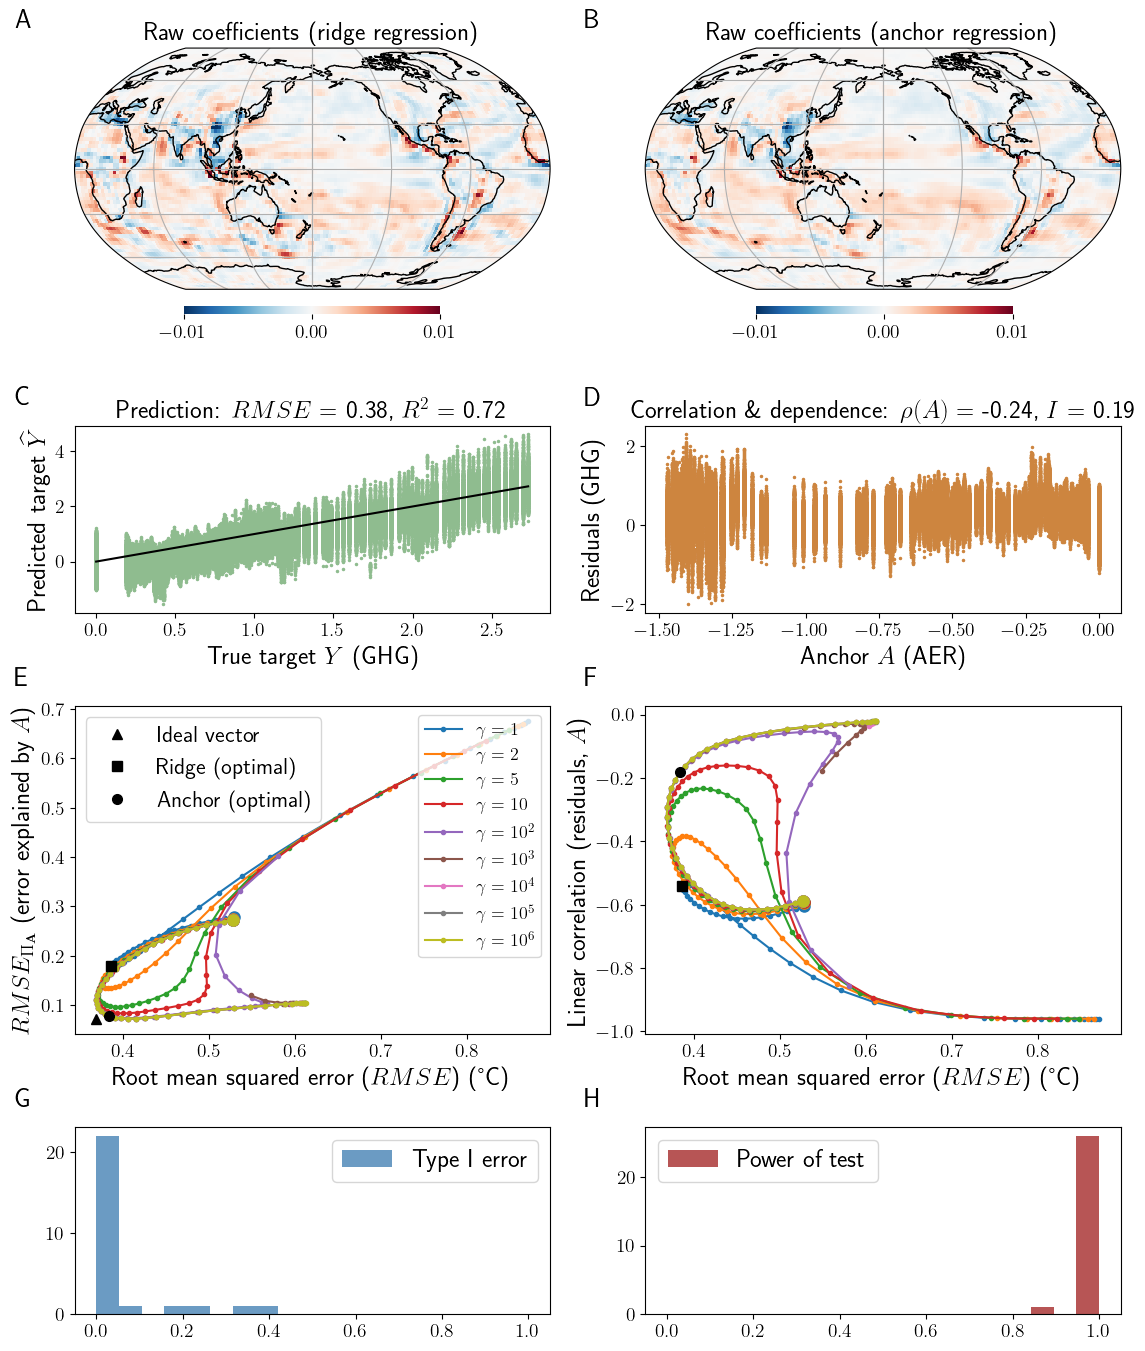

In [15]:
plots_small.plot_all_v2(
    np.mean(coef_raw_opt_lin, axis = 0), 
    np.mean(coef_raw_opt_ridge_lin, axis = 0), 
    y_test_true, 
    y_test_pred_lin, 
    y_test_pred_ridge_lin, 
    y_anchor_test,
    target, 
    anchor, 
    [],
    rmse_train_lin,
    rmse_PA_train_lin,
    corr_train_lin,
    mi_train_lin,
    gamma_vals,
    lambda_vals,
    ind_gamma_opt_lin,
    ind_lambda_opt_lin,
    ind_lambda_opt_ridge_lin,
    ind_vect_ideal_obj1_lin, 
    ind_vect_ideal_obj2_lin,
    alpha_bagging_lin,
    power_bagging_lin,
    formatFig = "pdf",
    # filename="aer_co2_lin_small.pdf",
)

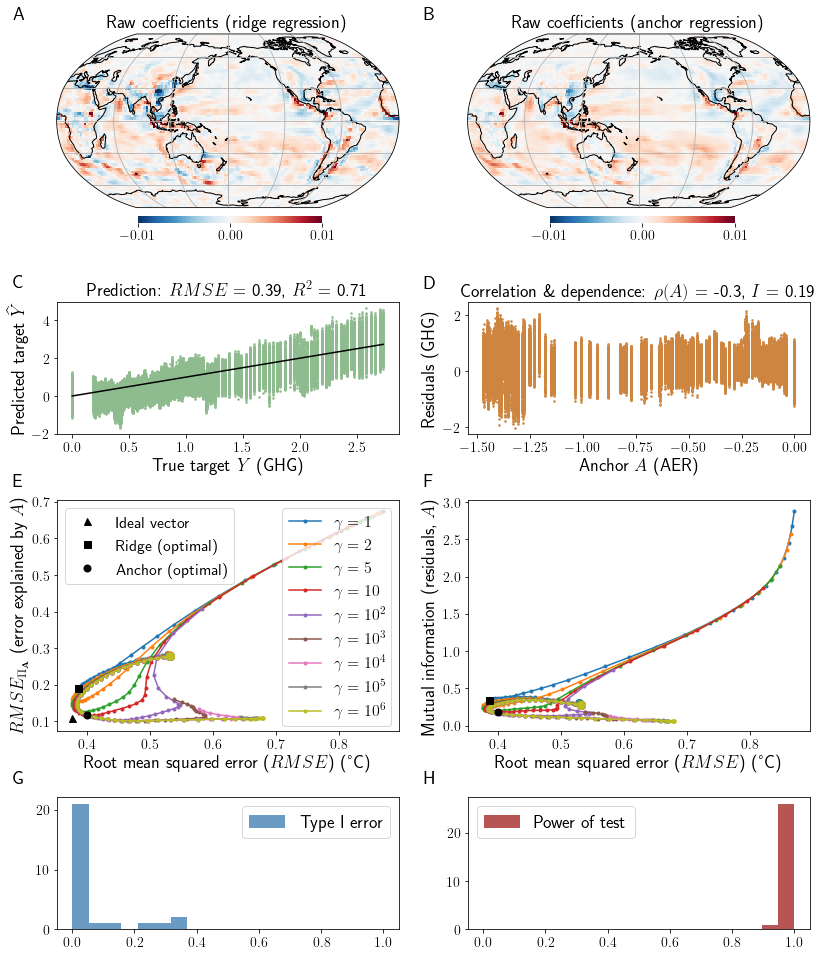

In [9]:
plots_small.plot_all_v2(
    np.mean(coef_raw_opt_nonlin, axis = 0), 
    np.mean(coef_raw_opt_ridge_nonlin, axis = 0), 
    y_test_true, 
    y_test_pred_nonlin, 
    y_test_pred_ridge_nonlin, 
    y_anchor_test,
    target, 
    anchor, 
    h_anchors,
    rmse_train_nonlin,
    rmse_PA_train_nonlin,
    corr_train_nonlin,
    mi_train_nonlin,
    gamma_vals,
    lambda_vals,
    ind_gamma_opt_nonlin,
    ind_lambda_opt_nonlin,
    ind_lambda_opt_ridge_nonlin,
    ind_vect_ideal_obj1_nonlin, 
    ind_vect_ideal_obj2_nonlin,
    alpha_bagging_nonlin,
    power_bagging_nonlin,
    formatFig = "svg",
    # filename="aer_co2_nonlin_small.svg",
)

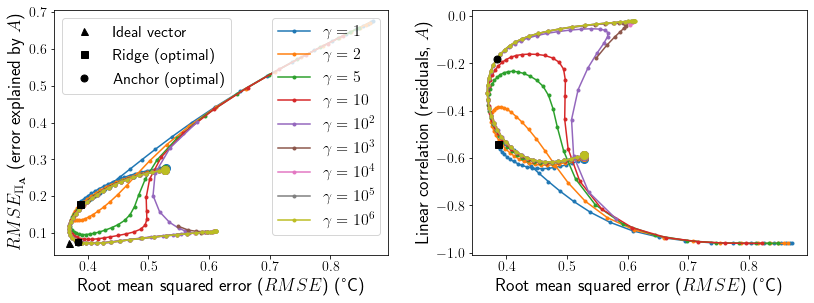

In [10]:
plots_small.plot_Pareto(
    rmse_train_lin,
    rmse_PA_train_lin,
    corr_train_lin,
    mi_train_lin,
    [],
    gamma_vals,
    lambda_vals,
    ind_gamma_opt_lin,
    ind_lambda_opt_lin,
    ind_lambda_opt_ridge_lin,
    ind_vect_ideal_obj1_lin, 
    ind_vect_ideal_obj2_lin,
    formatFig = "pdf",
    filename=None #"GHG_aer_hyperparameterOptim.png",
)

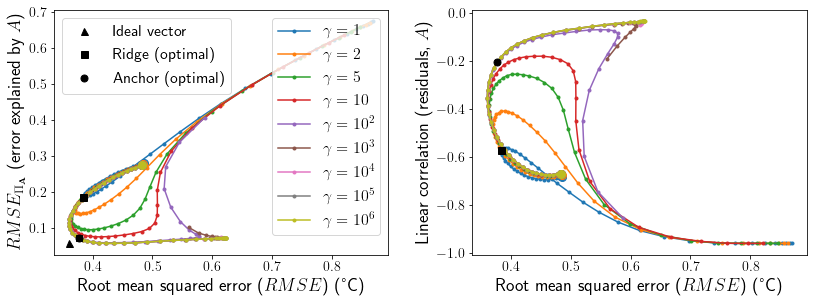

In [11]:
plots_small.plot_Pareto(
    rmse_test_lin,
    rmse_PA_test_lin,
    corr_test_lin,
    mi_test_lin,
    [],
    gamma_vals,
    lambda_vals,
    ind_gamma_opt_lin,
    ind_lambda_opt_lin,
    ind_lambda_opt_ridge_lin,
    ind_vect_ideal_obj1_lin, 
    ind_vect_ideal_obj2_lin,
    formatFig = "pdf",
    # filename="aer_co2_lin_test_small.pdf",
)

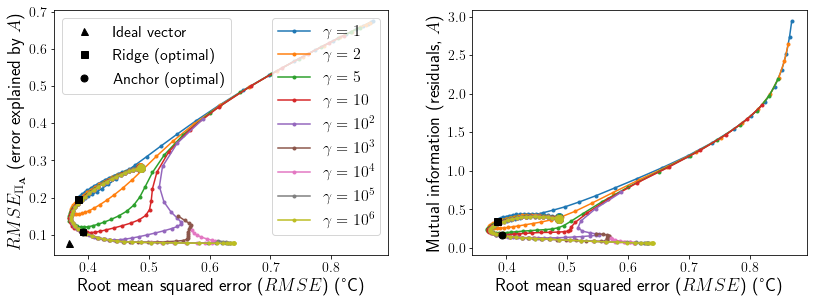

In [12]:
plots_small.plot_Pareto(
    rmse_test_nonlin,
    rmse_PA_test_nonlin,
    corr_test_nonlin,
    mi_test_nonlin,
    h_anchors,
    gamma_vals,
    lambda_vals,
    ind_gamma_opt_nonlin,
    ind_lambda_opt_nonlin,
    ind_lambda_opt_ridge_nonlin,
    ind_vect_ideal_obj1_nonlin, 
    ind_vect_ideal_obj2_nonlin,
    formatFig = "png",
    # filename="aer_co2_nonlin_test_small.png",
)

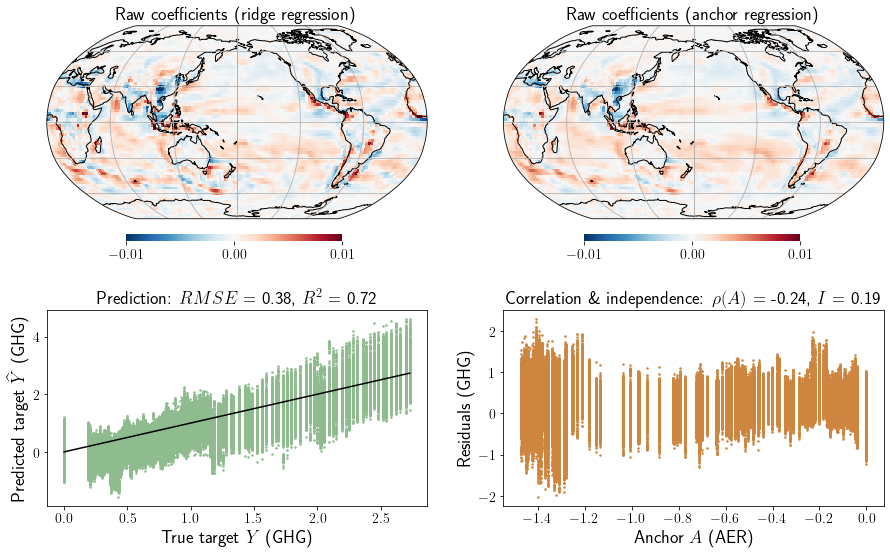

In [13]:
plots.plot_maps(
    np.mean(coef_raw_opt_lin, axis = 0), 
    np.mean(coef_raw_opt_ridge_lin, axis = 0), 
    y_test_true, 
    y_test_pred_lin, 
    y_test_pred_ridge_lin, 
    y_anchor_test,
    target, 
    anchor, 
    [],
    rmse_train_lin,
    rmse_PA_train_lin,
    corr_train_lin,
    mi_train_lin,
    gamma_vals,
    lambda_vals,
    ind_gamma_opt_lin,
    ind_lambda_opt_lin,
    ind_lambda_opt_ridge_lin,
    ind_vect_ideal_obj1_lin, 
    ind_vect_ideal_obj2_lin,
    filename=None #"GHG_aer_lin_maps.png",
)

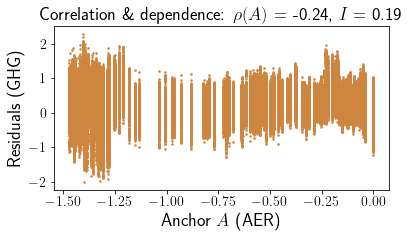

In [14]:
plots.plot_residuals(
    y_test_true, 
    y_test_pred_lin, 
    y_test_pred_ridge_lin, 
    y_anchor_test,
    target, 
    anchor, 
    [],
    rmse_train_lin,
    rmse_PA_train_lin,
    corr_train_lin,
    mi_train_lin,
    gamma_vals,
    lambda_vals,
    ind_gamma_opt_lin,
    ind_lambda_opt_lin,
    ind_lambda_opt_ridge_lin,
    ind_vect_ideal_obj1_lin, 
    ind_vect_ideal_obj2_lin,
    filename=None #"aer_co2_lin_residuals_ridge.png",
)